In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.inspection import permutation_importance

# EDA


In [3]:
df = pd.read_csv("ACME-HappinessSurvey2020.csv")

Let's do some exploratory data analysis


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


There are no missing data but the dataset is small. We should be careful with overfitting.

Let's check the class balance.


In [5]:
df["Y"].value_counts(normalize=True)

Y
1    0.547619
0    0.452381
Name: proportion, dtype: float64

55% are happy and 45% are unhappy. Seems pretty well balanced but this is misleading. More on that later.

For now let's see the summary statistics


In [6]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


We see that

- X1 has the largest mean (~4.33) and the lowest standard deviation (0.8), which means that satisfaction is high and variability is low. i.e. Most people are happy with little disagreement. X6 shows a similar case with a mean of ~ 4.25 and a std of ~0.81. Likewise for X4 with mean ~ 3.75 and std ~ 0.88.
- X2 has the lowest mean (~2.53) with one of the highest std (~1.11) and a median of 3.0. Since median > mean, the distribution is left skewed meaning there are some very low scores (1s and 2s) that pull the mean below the median. Most reponses cluster around 3 but overall satisfaction is low.
- X5 is also left skewed but the mean is higher (~3.65) with the highest std (~ 1.15). Most people are happy but there seems to be a large division between happy and unhappy people here.

Let's check the distribution of the features by plotting them on bar plots


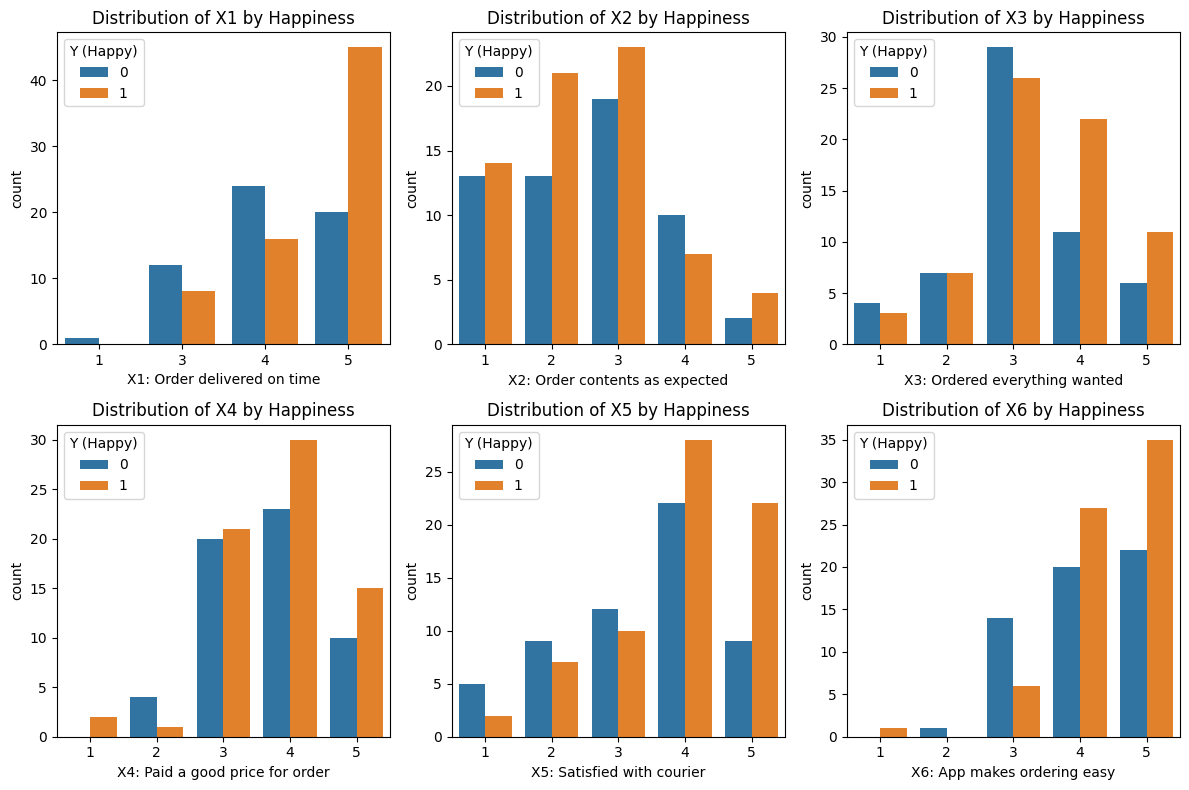

In [7]:
feature_explanations = {
    "X1": "X1: Order delivered on time",
    "X2": "X2: Order contents as expected",
    "X3": "X3: Ordered everything wanted",
    "X4": "X4: Paid a good price for order",
    "X5": "X5: Satisfied with courier",
    "X6": "X6: App makes ordering easy",
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(["X1", "X2", "X3", "X4", "X5", "X6"]):
    sns.countplot(data=df, x=col, hue="Y", ax=axes[i])
    axes[i].set_title(f"Distribution of {col} by Happiness")
    axes[i].set_xlabel(feature_explanations[col])
    axes[i].legend(title="Y (Happy)", loc="upper left")

plt.tight_layout()

As discussed earlier,

- Most people were happy about the app being easy to use (X6), paying a good price for their orders (X4) and orders being delivered on time (X1).
- Most people were unhappy because the content of their orders were not as expected (X2).

We also see that

- For X5, happy customers mostly rated their courier highly but the unhappy customers were more divided, explaining the high standard deviation from earlier.
- X3 is a bit of a mixed bag. Most people had a score of 3. If people were able to find the item that they wanted, they would be happy. Otherwise, they would be unhappy.


Let's validate this by looking at which features happy and unhappy customers differ the most as well as the correlation matrix


In [8]:
df.groupby("Y").mean().T.assign(
    diff=lambda x: x[1] - x[0], corr_with_Y=df.corr()["Y"].drop("Y")
).sort_values("diff", ascending=False)

Y,0,1,diff,corr_with_Y
X5,3.368421,3.884058,0.515637,0.224522
X1,4.087719,4.536232,0.448513,0.280160
X3,3.140351,3.449275,0.308924,0.150838
X6,4.105263,4.376812,0.271548,0.167669
X4,3.684211,3.797101,0.112891,0.064415
X2,2.561404,2.507246,-0.054157,-0.024274


The biggest variance/gaps are with X1 (~0.45) and X5 (~0.52).

For X1, the mean scores for the unhappy customers are still relatively high whereas for X5, the unhappy customers are leaning towards middle-low.

These two features are also the ones which correlate highest with the target. That is, they are the most likely to predict happiness.

On the opposite end, X2 has the highest negative correlation with Y (but still ~0). Everyone rated it poorly, which means that fixing X2 might improve overall satisfaction but not necessarily convert unhappy customer to happy customers.


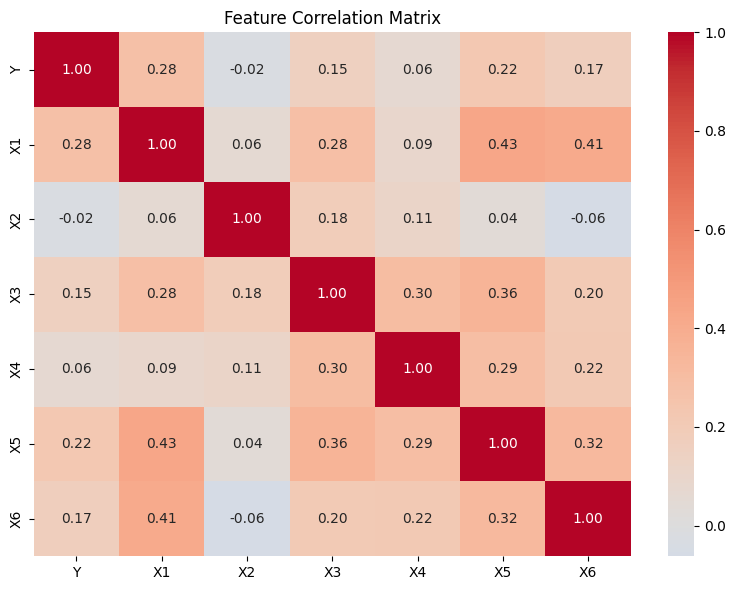

In [39]:
feature_corr = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(feature_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()


The correlation matrix shows moderate correlations between features, especially X5 and X1 (0.43), X6 and X1 (0.41), and X5 and X3 (0.36). This suggests that some features share some overlapping information.


# Unhappy customers


Recall that 55% of the customers were happy and 45% of the customers were unhappy. The dataset seems well balanced.

However, even if the dataset might be balanced in general, in a business persepective, it is unbalanced.

45% of customers being unhappy is alarming and the company gains more from saving an unhappy customer.

<br>

From our analysis above, we already have a strong candidate: X2, but do we have any other features that can help us predict the truly unhappy customers?


In [9]:
unhappy_df = df[df["Y"] == 0]
happy_df = df[df["Y"] == 1]

In [10]:
unhappy_df.apply(lambda x: (x <= 2).sum()).sort_values(ascending=False)

Y     57
X2    26
X5    14
X3    11
X4     4
X1     1
X6     1
dtype: int64

Unhappy customers were most unhappy that their orders were not as expected (X2), that there was something wrong with their courier/delivery (X5) and that some items were out of stock (X3).

<br>

Now that we've identified what unhappy customers complain about most, let's find out which of these features actually predict unhappiness.

Instead of maximizing accuracy, we should maximize **recall** for class 0.

<br>

**Note**: Models predict customers as happy or unhappy. If the model predicts everyone as happy we would still achieve 55% accuracy but that would be useless to us since it did not find any unhappy customers. A model that predicts everyone as unhappy would achieve 45% accuracy but then it would not flag any happy customers.

Recall ensures we prioritize identifying truly unhappy customers.


# Modeling


### Split Dataset and model recall for class 0


We split the dataset into features and target so the model can learn: given a customer's response, predict whether they're happy or unhappy.


In [11]:
X = df.drop("Y", axis=1)
y = df["Y"]

Instead of a traditional train/test split, we use cross validation since we have a very small dataset and want to avoid overfitting.

We compare recall using the following models:

- Logistic Regression since it's a good linear baseline
- Random Forest. Tree based ensemble, handles non-linear relationships
- Gradient Boosting. Tree based ensemble
- Support Vector Machine (SVM). Finds optimal decision boundaries, works well on small datasets


In [12]:
y_pred_log_reg = cross_val_predict(LogisticRegression(), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(), X, y)  # SVC is SVM but for classification

In [13]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier"
)

              precision    recall  f1-score   support

     Unhappy       0.48      0.42      0.45        57
       Happy       0.57      0.62      0.59        69

    accuracy                           0.53       126
   macro avg       0.52      0.52      0.52       126
weighted avg       0.53      0.53      0.53       126
 Logistic Regression
              precision    recall  f1-score   support

     Unhappy       0.47      0.46      0.46        57
       Happy       0.56      0.58      0.57        69

    accuracy                           0.52       126
   macro avg       0.52      0.52      0.52       126
weighted avg       0.52      0.52      0.52       126
 Random Forest
              precision    recall  f1-score   support

     Unhappy       0.51      0.49      0.50        57
       Happy       0.59      0.61      0.60        69

    accuracy                           0.56       126
   macro avg       0.55      0.55      0.55       126
weighted avg       0.55      0.56      0

For all models (class 0), the results are quite bad. Recall is below 50%.

However, this is our baseline. We might be able to improve by doing a few things like hyperparameter tuning.


### Hyperparameter Tuning


By default, models treat both classes equally. This means that with 55% happy and 45% unhappy, the model might lean towards predicting 'happy' more often.

We can try using class_weight='balanced' to adjust weights inversely proportional to class frequencies. That is, misclassifying an unhappy customer costs more than misclassifying a happy one.


In [14]:
y_pred_log_reg = cross_val_predict(LogisticRegression(class_weight="balanced"), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(class_weight="balanced"), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(class_weight="balanced"), X, y)

In [15]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression, balanced"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest, balanced"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier, balanced"
)

              precision    recall  f1-score   support

     Unhappy       0.53      0.56      0.55        57
       Happy       0.62      0.59      0.61        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression, balanced
              precision    recall  f1-score   support

     Unhappy       0.48      0.49      0.49        57
       Happy       0.57      0.57      0.57        69

    accuracy                           0.53       126
   macro avg       0.53      0.53      0.53       126
weighted avg       0.53      0.53      0.53       126
 Random Forest, balanced
              precision    recall  f1-score   support

     Unhappy       0.52      0.47      0.50        57
       Happy       0.59      0.64      0.62        69

    accuracy                           0.56       126
   macro avg       0.56      0.56      0.56       126
weighted avg       0

Results are better this time with SVM having the best recall for class 0 at 0.61 from 0.37. But let's see if we can do even better.

What this means in practice is that we went from catching 21 out of 57 unhappy customers to catching 35 out of 57 customers.

<br>

Since SVM scale sensitive (uses distance to find decision boundaries), maybe we can try transforming the data with the standard scaler (removes mean and scaling to unit variance). i.e. mean=0, std=1.


In [16]:
svc_pipe = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(class_weight="balanced"))]
)

In [17]:
y_pred_svc_pipe = cross_val_predict(svc_pipe, X, y)
y_pred_log_reg = cross_val_predict(LogisticRegression(class_weight="balanced"), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(class_weight="balanced"), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(class_weight="balanced"), X, y)

In [18]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression, balanced"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest, balanced"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier, balanced"
    + "\n"
    + classification_report(y, y_pred_svc_pipe, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier with standard scalar, balanced"
)

              precision    recall  f1-score   support

     Unhappy       0.53      0.56      0.55        57
       Happy       0.62      0.59      0.61        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression, balanced
              precision    recall  f1-score   support

     Unhappy       0.49      0.49      0.49        57
       Happy       0.58      0.58      0.58        69

    accuracy                           0.54       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0.54      0.54      0.54       126
 Random Forest, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.47      0.49        57
       Happy       0.58      0.61      0.60        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0

That didn't help. SVM with the standard scaler resulted in worst results than SVM just with class_weight=balanced likely because our features are already on the same 1-5 scale.

Let's try something else. Using GridSearch, we might be able to find an optimal set of parameters to maximize performance. Let's also try to see what we get when we optimize for accuracy.

<br>

**Note**: To avoid data leakage (tuning and evaluating on the same dataset), we use nested cross-validation. The inner loop (GridSearchCV) tunes hyperparameters while the outer loop gives an unbiased performance estimate.


In [19]:
params_grid = {
    "C": [
        0.01,
        0.1,
        1,
        10,
        100,
    ],  # Regularization parameter, low C = more regularization, allows more smoother, general decision boundary
    "kernel": ["linear", "rbf", "poly"],
}

recall_scorer = make_scorer(recall_score, pos_label=0)

In [20]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_recall = GridSearchCV(
    SVC(class_weight="balanced"),
    params_grid,
    scoring=recall_scorer,
    cv=inner_cv,
)

grid_accuracy = GridSearchCV(
    SVC(class_weight="balanced"),
    params_grid,
    scoring="accuracy",
    cv=inner_cv,
)

nested_recall = cross_val_score(grid_recall, X, y, cv=outer_cv, scoring=recall_scorer)
nested_accuracy_with_recall_tuned = cross_val_score(
    grid_recall, X, y, cv=outer_cv, scoring="accuracy"
)

nested_recall_with_accuracy_tuned = cross_val_score(
    grid_accuracy, X, y, cv=outer_cv, scoring=recall_scorer
)
nested_accuracy = cross_val_score(grid_accuracy, X, y, cv=outer_cv, scoring="accuracy")

grid_recall.fit(X, y)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_weight='balanced')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'kernel': ['linear', 'rbf', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","make_scorer(r..., pos_label=0)"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidat

In [21]:
print(
    "Recall-tuned model: \n"
    + f" Recall: {nested_recall.mean():.3f}, Accuracy: {nested_accuracy_with_recall_tuned.mean():.3f} \n\n"
    + "Accuracy-tuned model: \n"
    + f" Recall: {nested_recall_with_accuracy_tuned.mean():.3f}, Accuracy: {nested_accuracy.mean():.3f} \n\n"
    + f"Inner CV Recall (class 0): {grid_recall.best_score_:.3f} \n"
    + f"Best parameters: {grid_recall.best_params_}"
)

Recall-tuned model: 
 Recall: 0.752, Accuracy: 0.572 

Accuracy-tuned model: 
 Recall: 0.600, Accuracy: 0.571 

Inner CV Recall (class 0): 0.668 
Best parameters: {'C': 0.01, 'kernel': 'poly'}


The inner loop found that C=0.01 and a polynomial kernel were the best parameters.

Both recall tuned and accuracy tuned models achieved ~0.57 accuracy (higher than our previous scores) but the recall tuned model had a much higher recall at 0.75.

<br>

**Note**: The nested CV score (~0.75) is different from the fixed parameter inner CV score (~0.67) because nestedCV retunes hyperparameters on each outer fold.

<br>

This shows that recall optimization is the superior solution. We gained performance in recall at no accuracy cost.

This 0.75 recall is the best estimate of how the model will perform on new unseen data.

<br>

For completion, let's verify that 0.57 accuracy is the best we can get with the four models.


In [30]:
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight="balanced", max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["lbfgs", "liblinear"],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [2, 3, 5],
            "learning_rate": [0.01, 0.1, 0.2],
        },
    },
    "SVM": {
        "model": SVC(class_weight="balanced"),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "kernel": ["linear", "rbf", "poly"],
        },
    },
}

results = []

for name, config in param_grids.items():
    grid = GridSearchCV(
        config["model"],
        config["params"],
        scoring="accuracy",
        cv=inner_cv,
        n_jobs=-1,
    )

    nested_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring="accuracy")

    grid.fit(X, y)

    results.append(
        {
            "Model": name,
            "Accuracy": nested_scores.mean(),
            "Std": nested_scores.std(),
            "Best Params": grid.best_params_,
        }
    )

    print(f"{name}:")
    print(f"  Accuracy: {nested_scores.mean():.3f} ± {nested_scores.std():.3f}")
    print(f"  Best params: {grid.best_params_}\n")

/usr/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.14/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Logistic Regression:
  Accuracy: 0.587 ± 0.066
  Best params: {'C': 0.01, 'solver': 'lbfgs'}

Random Forest:
  Accuracy: 0.595 ± 0.040
  Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

Gradient Boosting:
  Accuracy: 0.627 ± 0.039
  Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

SVM:
  Accuracy: 0.571 ± 0.057
  Best params: {'C': 0.01, 'kernel': 'poly'}



The best result was Gradient Boosting at ~0.63 accuracy with all four tuned models being in the ~0.57 to ~0.63 range.

This suggests that despite tuning across multiple models, we will not be able to achieve a 73% accuracy score and that there is a limitation in the dataset (e.g. small sample size, weak feature to target correlation etc.).

Therefore further optimizing for accuracy does not make sense and as previously stated, recall optimization is the way to go.


### Permutation Feature Importance


Now let's answer the bonus question: which features actually matter for predicting unhappiness? And can we remove any unnecessary ones?

By identifying the minimal feature set on our best model (tuned SVM), we can simplify future surveys while keeping the predictive power.


In [31]:
tuned_svm = SVC(C=0.01, kernel="poly", class_weight="balanced")
tuned_svm.fit(X, y)

perm = permutation_importance(
    tuned_svm, X, y, scoring=recall_scorer, n_repeats=30, random_state=42
)

importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": perm.importances_mean}
).sort_values("Importance", ascending=False)

importance_df


,Feature,Importance
0,X1,0.103509
1,X2,0.054971
5,X6,0.046199
2,X3,0.045614
3,X4,0.039181
4,X5,0.035088


We see that X1 contributed the most followed by X2, X6, X3, X4 then X5 but importance does not equate to necessity. Can we figure out which ones are really necessary?

<br>

**Note**: Recall from the EDA section that X5 had the largest mean difference between unhappy and happy customers. In the permutation importance results, we see that X5 is ranked the least important. This makes sense since X5 correlates with X1 and X3 (see correlation matrix above), and is deemed 'redundant'.


### Feature Engineering - Minimal Feature Set


Recursive feature elimination with cross-validation (RFECV) on SVM requires us to use a kernel other than 'poly'. This does not give us the result we want so we have to take another approach.

Let's try dropping each feature and seeing how recall changes. We first use cross validation with the optimal fixed hyperparameters to find the minimal set.


In [32]:
all_features = ["X1", "X2", "X3", "X4", "X5", "X6"]

scores = cross_val_score(
    tuned_svm, X[all_features], y, cv=outer_cv, scoring=recall_scorer
)

In [40]:
print("Baseline (all 6): \n" + f" Recall = {scores.mean():.3f} ± {scores.std():.3f}\n")

print("Drop one feature:")
for drop in all_features:
    features = [f for f in all_features if f != drop]
    scores = cross_val_score(
        tuned_svm, X[features], y, cv=outer_cv, scoring=recall_scorer
    )
    print(f" Drop {drop}: Recall = {scores.mean():.3f} ± {scores.std():.3f}")


Baseline (all 6): 
 Recall = 0.632 ± 0.063

Drop one feature:
 Drop X1: Recall = 0.580 ± 0.097
 Drop X2: Recall = 0.685 ± 0.086
 Drop X3: Recall = 0.633 ± 0.074
 Drop X4: Recall = 0.652 ± 0.087
 Drop X5: Recall = 0.652 ± 0.065
 Drop X6: Recall = 0.632 ± 0.063
 Drop X6: Recall = 0.632 ± 0.063


We see that

- Dropping X1 hurts our score (=0.58) while dropping X2 increases the score (=~0.69)
- Dropping X4 and X5 does not affect the model much (=0.65)
- Dropping X3 and X6 results in a lower score (=0.63), maybe a bit too low for our liking.

Let's test combinations that drop X2.


In [26]:
test_sets = {
    "Drop X2": ["X1", "X3", "X4", "X5", "X6"],
    "Drop X2, X4": ["X1", "X3", "X5", "X6"],
    "Drop X2, X5": ["X1", "X3", "X4", "X6"],
    "Drop X2, X4, X5": ["X1", "X3", "X6"],
}

In [27]:
print("Promising combinations:")
for name, features in test_sets.items():
    scores = cross_val_score(
        tuned_svm, X[features], y, cv=outer_cv, scoring=recall_scorer
    )
    print(f"{name}: Recall = {scores.mean():.3f} ± {scores.std():.3f}")


Promising combinations:
Drop X2: Recall = 0.685 ± 0.086
Drop X2, X4: Recall = 0.703 ± 0.083
Drop X2, X5: Recall = 0.667 ± 0.062
Drop X2, X4, X5: Recall = 0.739 ± 0.103


Dropping X2, X4 and X5 improves recall from ~0.67 to ~0.74.

Let's validate this with the nested CV model (gridsearch). The recall for this model with 6 features was ~0.75.

If we can get ~0.75 with the 3 feature set, then we can confirm that the minimal feature set is [X1, X3, X6].


In [28]:
nested_reduced = cross_val_score(
    grid_recall, X[["X1", "X3", "X6"]], y, cv=outer_cv, scoring=recall_scorer
)

In [29]:
print(
    f"Nested CV (3 features): {nested_reduced.mean():.3f} ± {nested_reduced.std():.3f}"
)

Nested CV (3 features): 0.753 ± 0.147


The result is now clear. Our minimal feature set is X1, X3, and X6.

We can remove X2, X4 and X5 from future surveys, which reduces survey length by 50% without reducing model performance for identifying unhappy customers.

<br>

**Note**: The high standard deviation is a reflection of the small sample size:

- We used a StratifiedKfold of 5 splits. So 126 samples / 5 = ~25 samples per test fold.
- ~45% are unhappy so 25\*0.45 = ~ 11 unhappy customer per fold
- Identifying one more/less correct = ~9% swing in recall


# Conclusion


**Goal**: Predict customer happiness or unhappiness with 73% accuracy or justify a superior solution.

**Approach**: Focus on identifying unhappy customers (recall for class 0) instead of overall accuracy because this has a higher business value as 45% of customers are dissatisfied.

- Our tuned SVM with nested cross validation (optimal parameters: C=0.01, polynomial kernel) achieved 75.2% recall for unhappy customers. That means we can identify 3 out of 4 unsatisfied customers.

- All four tuned models had an accuracy score in ~57-63% range, which shows that accuracy plateaus at ~63% regardless of optimization but the recall-tuned SVM model also achieved 75% recall vs only 60% for the accuracy tuned SVM model, thereby identifying 15% more unhappy customers at no accuracy cost.

- The top complaints from the customer survey were X2 (contents of my order was as I expected) and X5 (I am satisfied with my courier). It's a universal pain point and adds noise to the model.

- Removing features X2, X4 (I paid a good price for my order) and X5 from the survey resulted in comparable model performance (from 0.752 to 0.753). That is, we reduced survey length by 50% while keeping model performance by going from a 6 feature set to a 3 feature set.

**Recommendations**:

- Prioritize X1, X3, X6 or
- Reduce survey length from 6 questions to 3 questions (X1, X3, X6)
